<a href="https://colab.research.google.com/github/nye0/SAM-Med2D/blob/main/predictor_example.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Environment Set-up
edit from [sam colab](https://colab.research.google.com/github/facebookresearch/segment-anything/blob/main/notebooks/automatic_mask_generator_example.ipynb#scrollTo=MTeAdX_mHwAR)



If you're running this notebook locally using Jupyter, please clone `SAM-Med2D` into a directory named `SAM_Med2D`. Note that you do **not** need to install `segment_anything` in your local environment, as `SAM-Med2D` and `SAM` share function names that could lead to conflicts.

For Google Colab users: Set `using_colab=True` in the cell below before executing it. Although you can select 'GPU' under 'Edit' -> 'Notebook Settings' -> 'Hardware Accelerator', this notebook is designed to run efficiently in a CPU environment as well.



# SAM-Med2D generates predicted object masks based on prompts.

In [1]:
import sys

import cv2
import matplotlib.pyplot as plt
import numpy as np
import SimpleITK as sitk
import torch
import torch.nn.functional as F
from skimage.measure import label, regionprops

In [2]:
def show_mask(mask, ax, random_color=False):
    if random_color:
        color = np.array([0, 1, 0, 0.5])
    else:
        color = np.array([1, 0, 0, 0.5])
    h, w = mask.shape[-2:]
    mask_image = mask.reshape(h, w, 1) * color.reshape(1, 1, -1)
    ax.imshow(mask_image)


def show_points(coords, labels, ax, marker_size=100):
    pos_points = coords[labels == 1]
    neg_points = coords[labels == 0]
    ax.scatter(
        pos_points[:, 0],
        pos_points[:, 1],
        color="green",
        marker=".",
        s=marker_size,
        edgecolor="white",
        linewidth=1.25,
    )
    ax.scatter(
        neg_points[:, 0],
        neg_points[:, 1],
        color="red",
        marker=".",
        s=marker_size,
        edgecolor="white",
        linewidth=1.25,
    )


def show_box(box, ax):
    x0, y0 = box[0], box[1]
    w, h = box[2] - box[0], box[3] - box[1]
    ax.add_patch(
        plt.Rectangle((x0, y0), w, h, edgecolor="green", facecolor=(0, 0, 0, 0), lw=1)
    )

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

## Load SAM-Med2D model

In [4]:
from argparse import Namespace

from segment_anything import sam_model_registry
from segment_anything.predictor_sammed import SammedPredictor

args = Namespace()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
args.image_size = 256
args.encoder_adapter = True
args.sam_checkpoint = "/volume/willy-dev/sota/SAM-Med2D/sam-med2d_b.pth"
model = sam_model_registry["vit_b"](args).to(device)
predictor = SammedPredictor(model)

True
*******load /volume/willy-dev/sota/SAM-Med2D/sam-med2d_b.pth


In [5]:
args = Namespace()
args.image_size = 1024
args.encoder_adapter = False
args.sam_checkpoint = "/volume/willy-dev/sota/SAM-Med2D/sam_vit_b_01ec64.pth"
model2 = sam_model_registry["vit_b"](args).to(device)
predictor2 = SammedPredictor(model2)

*******load /volume/willy-dev/sota/SAM-Med2D/sam_vit_b_01ec64.pth


In [6]:
import hydra
from cutie.inference.inference_core import InferenceCore
from cutie.inference.utils.args_utils import get_dataset_cfg
from cutie.model.cutie import CUTIE
from gui.interactive_utils import (
    image_to_torch,
    index_numpy_to_one_hot_torch,
    overlay_davis,
    torch_prob_to_numpy_mask,
)
from hydra import compose, initialize
from omegaconf import open_dict

hydra.core.global_hydra.GlobalHydra.instance().clear()

with torch.inference_mode():
    initialize(
        version_base="1.3.2", config_path="Cutie/cutie/config", job_name="eval_config"
    )
    cfg = compose(config_name="eval_config")

    with open_dict(cfg):
        cfg["weights"] = (
            "/volume/willy-dev/sota/SAM-Med2D/Cutie/weights/cutie-base-mega.pth"
        )

    data_cfg = get_dataset_cfg(cfg)

    # Load the network weights
    cutie = CUTIE(cfg).cuda().eval()
    model_weights = torch.load(cfg.weights)
    cutie.load_weights(model_weights)

processor = InferenceCore(cutie, cfg=cfg)

In [7]:
import glob
import os

from tqdm import tqdm

In [8]:
def get_slice(img, mask, index):

    slce = img[index].astype(float)
    slce -= slce.min()
    slce /= slce.max()
    slce *= 255
    slce = slce.astype(np.uint8)
    slce = np.stack([slce, slce, slce], axis=2)

    gt = mask[index]

    return np.copy(slce), np.copy(gt)


def get_predict(img, predictor, point=None, box=None):

    predictor.set_image(slce)

    if point is not None:
        input_point = np.array([point])
        input_label = np.array([1])
    else:
        input_point, input_label = None, None

    if box is not None:
        box = np.array([box])
    else:
        box = None

    masks, scores, logits = predictor.predict(
        point_coords=input_point,
        point_labels=input_label,
        box=box,
        multimask_output=True,
    )

    return masks[0]

    return predictor.model.image_encoder(x).flatten().unsqueeze(0)

In [9]:
def visualize(slce, predict_mask, gt, box, fn):
    plt.figure(figsize=(5, 5))
    plt.imshow(slce)
    show_mask(gt, plt.gca(), random_color=True)
    show_mask(predict_mask, plt.gca())
    show_box(box, plt.gca())
    plt.axis("off")
    plt.show()
    # plt.savefig(f"output/{fn}")

In [10]:
def visualize(slce, predict_mask, gt, points, labels, fn):
    plt.figure(figsize=(5, 5))
    plt.imshow(slce)
    # show_mask(gt, plt.gca(), random_color=True)
    show_mask(predict_mask, plt.gca())
    show_points(points, labels, plt.gca())
    plt.axis("off")
    # plt.show()
    plt.savefig(f"output/{fn}")

In [11]:
def pad_box(box, pad):
    h, w = box[3] - box[1], box[2] - box[0]
    y, x = (box[3] + box[1]) / 2, (box[2] + box[0]) / 2
    box = np.array([y - h / 2 * pad, x - w / 2 * pad, y + h / 2 * pad, x + w / 2 * pad])
    return box

In [12]:
fns = os.listdir("/volume/open-dataset-nas/AMOS/amos22/imagesTr")
import torch.nn.functional as F

In [19]:
from torchvision import ops

dices = []
dicesb = []

for fn in tqdm(fns[193:]):

    if ".nii.gz" not in fn:
        continue

    img = sitk.ReadImage(f"/volume/open-dataset-nas/AMOS/amos22/imagesTr/{fn}")
    img = sitk.GetArrayFromImage(img)

    mask = sitk.ReadImage(f"/volume/open-dataset-nas/AMOS/amos22/labelsTr/{fn}")
    mask = sitk.GetArrayFromImage(mask)

    mask = mask.astype(int)
    mask[mask != 1] = 0
    mask[mask == 1] = 1

    img = np.clip(img, -350, 450)

    if img.shape[1] != img.shape[2]:
        max_l = max(img.shape[1], img.shape[2])

        pad_h1 = (max_l - img.shape[1]) // 2
        pad_h2 = max_l - pad_h1 - img.shape[1]

        pad_w1 = (max_l - img.shape[2]) // 2
        pad_w2 = max_l - pad_w1 - img.shape[2]

        img = torch.tensor(img)
        img = F.pad(img, (pad_w1, pad_w2, pad_h1, pad_h2), "constant", 0).numpy()
        mask = torch.tensor(mask)
        mask = F.pad(mask, (pad_w1, pad_w2, pad_h1, pad_h2), "constant", 0).numpy()

    for i, prop in enumerate(regionprops(mask)):

        dices_tp = 0
        dices_pred = 0

        init_center = ((np.array(prop.bbox[:3]) + np.array(prop.bbox[3:])) / 2).astype(
            int
        )

        z = init_center[0]
        slce, gt = get_slice(img, mask, z)

        gt[gt != (i + 1)] = 0
        gt[gt == (i + 1)] = 1

        predict_mask = gt

        frame_torch = image_to_torch(slce, device=device)
        mask_torch = index_numpy_to_one_hot_torch(predict_mask, 2).to(device)

        mask_torch = F.interpolate(mask_torch.unsqueeze(0), (480, 480))[0]
        init_mask_torch = torch.zeros(4, 480, 480).cuda()
        init_mask_torch[0] = mask_torch[1]

        init_frame_torch = F.interpolate(frame_torch.unsqueeze(0), (480, 480))[0]

        with torch.inference_mode():
            processor.clear_memory()
            prediction = processor.step(
                init_frame_torch, init_mask_torch, idx_mask=False
            )

        dices_tp += gt.sum()
        dices_pred += gt.sum()
        dices.append(1)

        z = init_center[0] + 1
        while z < img.shape[0]:

            slce, gt = get_slice(img, mask, z)

            gt[gt != (i + 1)] = 0
            gt[gt == (i + 1)] = 1
            if gt.sum() == 0:
                break

            frame_torch = image_to_torch(slce, device=device)
            frame_torch = F.interpolate(frame_torch.unsqueeze(0), (480, 480))[0]

            with torch.inference_mode():
                prediction = processor.step(frame_torch)

            prediction = torch_prob_to_numpy_mask(prediction)

            prediction = torch.tensor(prediction).float().unsqueeze(0).unsqueeze(0)
            prediction = F.interpolate(prediction, (gt.shape[0], gt.shape[1]))[0][0]

            regionprop = regionprops(prediction.int().cpu().numpy())

            if len(regionprop) == 0:
                break

            box, area = regionprop[0].bbox, regionprop[0].area
            h, w = box[2] - box[0], box[3] - box[1]
            box = pad_box(box, 1.0)

            predictor2.set_image(slce)
            masks, scores, logits = predictor2.predict(
                box=box,
                multimask_output=False,
            )

            mask_torch = torch.zeros(4, 480, 480).cuda()
            pred_torch = torch.tensor(masks).cuda()
            mask_torch[0] = F.interpolate(pred_torch.unsqueeze(0), (480, 480))[0][0]

            with torch.inference_mode():
                processor.clear_memory()
                processor.step(frame_torch, mask_torch, idx_mask=False)

            # visualize(slce, masks[0], gt, box, "")

            dices_tp += (gt * masks[0]).sum()
            dices_pred += masks[0].sum()
            dice_ = 2 * (gt * masks[0]).sum() / (gt.sum() + masks[0].sum() + 1e-5)
            dices.append(dice_)

            z += 1

        with torch.inference_mode():
            processor.clear_memory()
            prediction = processor.step(
                init_frame_torch, init_mask_torch, idx_mask=False
            )

        z = init_center[0] - 1
        while z >= 0:
            slce, gt = get_slice(img, mask, z)

            gt[gt != (i + 1)] = 0
            gt[gt == (i + 1)] = 1
            if gt.sum() == 0:
                break

            frame_torch = image_to_torch(slce, device=device)
            frame_torch = F.interpolate(frame_torch.unsqueeze(0), (480, 480))[0]

            with torch.inference_mode():
                prediction = processor.step(frame_torch)

            prediction = torch_prob_to_numpy_mask(prediction)

            prediction = torch.tensor(prediction).float().unsqueeze(0).unsqueeze(0)
            prediction = F.interpolate(prediction, (gt.shape[0], gt.shape[1]))[0][0]

            regionprop = regionprops(prediction.int().cpu().numpy())

            if len(regionprop) == 0:
                break

            box, area = regionprop[0].bbox, regionprop[0].area
            h, w = box[2] - box[0], box[3] - box[1]
            box = pad_box(box, 1.0)

            predictor.set_image(slce)
            masks, scores, logits = predictor.predict(
                box=box,
                multimask_output=True,
            )

            mask_torch = torch.zeros(4, 480, 480).cuda()
            pred_torch = torch.tensor(masks).cuda()
            mask_torch[0] = F.interpolate(pred_torch.unsqueeze(0), (480, 480))[0][0]

            with torch.inference_mode():
                processor.clear_memory()
                processor.step(frame_torch, mask_torch, idx_mask=False)

            # visualize(slce, masks[0], gt, box, "")

            dices_tp += (gt * masks[0]).sum()
            dices_pred += masks[0].sum()
            dice_ = 2 * (gt * masks[0]).sum() / (gt.sum() + masks[0].sum() + 1e-5)
            dices.append(dice_)

            z -= 1

        dicesb_ = 2 * dices_tp / (dices_pred + prop.area)
        dicesb.append(dicesb_)

        tqdm.write(f"{dicesb_} {np.mean(dices)}")

  2%|█▌                                                                          | 1/48 [00:03<03:02,  3.89s/it]

0.9663215657581855 0.9402885434191828


  4%|███▏                                                                        | 2/48 [00:10<04:02,  5.26s/it]

0.9379220014417854 0.9255097054374023


  6%|████▊                                                                       | 3/48 [00:12<02:54,  3.87s/it]

0.9441297280460978 0.9248025411325326


  8%|██████▎                                                                     | 4/48 [00:15<02:32,  3.47s/it]

0.9392872491652616 0.9231649251903732


 10%|███████▉                                                                    | 5/48 [00:19<02:40,  3.74s/it]

0.9318240186491239 0.9150242545654194


 12%|█████████▌                                                                  | 6/48 [00:27<03:44,  5.34s/it]

0.9620020851639968 0.9254231633397518


 15%|███████████                                                                 | 7/48 [00:29<02:54,  4.25s/it]

0.9173368671175288 0.9225538144286026


 17%|████████████▋                                                               | 8/48 [00:34<02:59,  4.49s/it]

0.8987278527230101 0.907547950727511


 19%|██████████████▎                                                             | 9/48 [00:37<02:28,  3.80s/it]

0.9237941065494955 0.9064922920973285


 21%|███████████████▋                                                           | 10/48 [00:44<03:08,  4.96s/it]

0.9565734577673597 0.910748322899012


 23%|█████████████████▏                                                         | 11/48 [00:46<02:29,  4.05s/it]

0.8917911656998412 0.9080960115286456


 25%|██████████████████▊                                                        | 12/48 [00:49<02:08,  3.58s/it]

0.9216092271353855 0.9060981868395692


 27%|████████████████████▎                                                      | 13/48 [00:56<02:45,  4.74s/it]

0.9373440441273038 0.9032679042547921


 29%|█████████████████████▉                                                     | 14/48 [01:05<03:24,  6.02s/it]

0.9377056867471257 0.9025366228285147


 31%|███████████████████████▍                                                   | 15/48 [01:13<03:39,  6.65s/it]

0.9532892911103574 0.9057589534389688


 33%|█████████████████████████                                                  | 16/48 [01:17<03:04,  5.76s/it]

0.8473635441414775 0.9033880804142418


 35%|██████████████████████████▌                                                | 17/48 [01:32<04:29,  8.70s/it]

0.3188145991473432 0.7821252901186734


 38%|████████████████████████████▏                                              | 18/48 [01:37<03:39,  7.32s/it]

0.7987004664277872 0.7800148227254717


 40%|█████████████████████████████▋                                             | 19/48 [01:58<05:38, 11.69s/it]

0.8900961791423575 0.7968738624024432


 42%|███████████████████████████████▎                                           | 20/48 [02:03<04:24,  9.44s/it]

0.9346694729787747 0.799964107937855


 44%|████████████████████████████████▊                                          | 21/48 [02:05<03:21,  7.46s/it]

0.9086631779996583 0.8018966010342733


 46%|██████████████████████████████████▍                                        | 22/48 [02:10<02:50,  6.54s/it]

0.9414252918879183 0.8044686678686791


 48%|███████████████████████████████████▉                                       | 23/48 [02:12<02:14,  5.37s/it]

0.9558668101273055 0.8075401981436336


 50%|█████████████████████████████████████▌                                     | 24/48 [02:15<01:50,  4.61s/it]

0.8261342253815597 0.806351695839727


 52%|███████████████████████████████████████                                    | 25/48 [02:19<01:40,  4.39s/it]

0.8659626222963321 0.8062375421215853


 54%|████████████████████████████████████████▋                                  | 26/48 [02:22<01:25,  3.87s/it]

0.7958881998131 0.8049198852826194


 56%|██████████████████████████████████████████▏                                | 27/48 [02:24<01:12,  3.48s/it]

0.8815692465799331 0.8058172841904684


 58%|███████████████████████████████████████████▊                               | 28/48 [02:31<01:31,  4.55s/it]

0.8026788424947623 0.8020149846536471


 60%|█████████████████████████████████████████████▎                             | 29/48 [02:35<01:22,  4.33s/it]

0.9582852677408551 0.8066520928908577


 62%|██████████████████████████████████████████████▉                            | 30/48 [02:44<01:39,  5.55s/it]

0.959708124578998 0.8134167732126769


 65%|████████████████████████████████████████████████▍                          | 31/48 [02:52<01:46,  6.24s/it]

0.9725099635813922 0.8207945479242696


 67%|██████████████████████████████████████████████████                         | 32/48 [02:54<01:23,  5.20s/it]

0.8830598268510144 0.8210040389556204


 69%|███████████████████████████████████████████████████▌                       | 33/48 [03:02<01:31,  6.10s/it]

0.9530598031794095 0.825804316000698


 71%|█████████████████████████████████████████████████████▏                     | 34/48 [03:11<01:33,  6.70s/it]

0.9576610831363683 0.8307743943187913


 73%|██████████████████████████████████████████████████████▋                    | 35/48 [03:15<01:18,  6.06s/it]

0.9011778207996661 0.8311985179228526


 75%|████████████████████████████████████████████████████████▎                  | 36/48 [03:17<00:56,  4.70s/it]

0.8630113732812765 0.8309428420783929


 77%|█████████████████████████████████████████████████████████▊                 | 37/48 [03:20<00:46,  4.24s/it]

0.601649425561329 0.8276089151959158


 79%|███████████████████████████████████████████████████████████▍               | 38/48 [03:23<00:38,  3.84s/it]

0.8314175492372887 0.8252365001956405


 81%|████████████████████████████████████████████████████████████▉              | 39/48 [03:26<00:32,  3.61s/it]

0.8421303573690131 0.8250029587314223


 83%|██████████████████████████████████████████████████████████████▌            | 40/48 [03:28<00:26,  3.30s/it]

0.6051655083048652 0.821722486138046


 85%|████████████████████████████████████████████████████████████████           | 41/48 [03:31<00:21,  3.03s/it]

0.9393894542090657 0.8225595061213936


 88%|█████████████████████████████████████████████████████████████████▋         | 42/48 [03:35<00:19,  3.25s/it]

0.7632493543601296 0.8216199701424352


 90%|███████████████████████████████████████████████████████████████████▏       | 43/48 [03:37<00:15,  3.14s/it]

0.9506904676062952 0.8229187203185278


 92%|████████████████████████████████████████████████████████████████████▊      | 44/48 [03:40<00:11,  2.89s/it]

0.9202383485848052 0.8231796846460416


 94%|██████████████████████████████████████████████████████████████████████▎    | 45/48 [03:44<00:09,  3.16s/it]

0.8344035060897926 0.8227862400875057


 96%|███████████████████████████████████████████████████████████████████████▉   | 46/48 [03:46<00:05,  2.95s/it]

0.944818413326629 0.8241065572722326


 98%|█████████████████████████████████████████████████████████████████████████▍ | 47/48 [03:51<00:03,  3.53s/it]

0.9404854139179653 0.8252775528970006


100%|███████████████████████████████████████████████████████████████████████████| 48/48 [03:59<00:00,  5.00s/it]

0.9517593862671879 0.8270649695428197


In [ ]:
np.save("tmp_dices_organ.npy", dices)
np.save("tmp_dicesb_organ.npy", dicesb)

In [20]:
dices = np.array(dices)
dicesb = np.array(dicesb)

0.8270649695428197


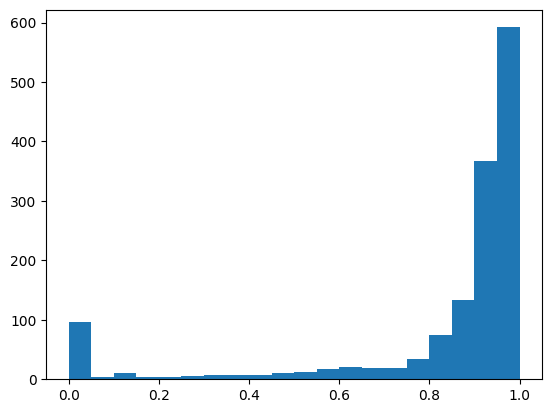

In [21]:
print(np.mean(dices))
plt.hist(dices, bins=20)
plt.show()

0.8825283640334064


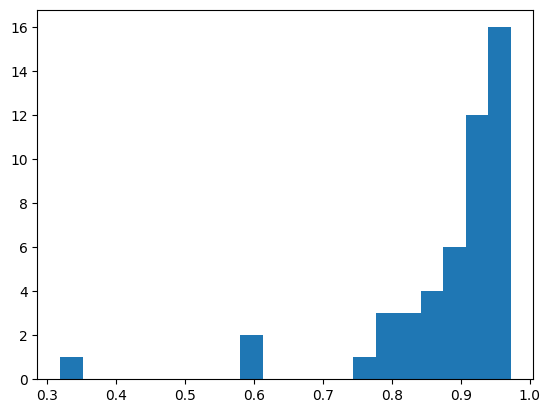

In [22]:
print(np.mean(dicesb))
plt.hist(dicesb, bins=20)
plt.show()

In [14]:
img.shape

(20, 512, 512)